# Setup

In [189]:
single_match=False

In [2]:
import os
import utils.envsetup
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
from transformers import AutoTokenizer

if single_match:
    from utils.ex_aspire_consent import AspireConSent, prepare_abstracts
else:
    from utils.ex_aspire_consent_multimatch import AspireConSent, AllPairMaskedWasserstein
    from utils.ex_aspire_consent_multimatch import prepare_abstracts

import time
import tqdm
import torch
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Dataset Setup

In [4]:
from collections import namedtuple
from data.pmc_iterable import PMCIterable
from data.topic_iterable import TopicIterable
import pickle
import torch
from torch.utils.data import DataLoader
from utils.doc_abstract_to_sentence_list_transform import DocAbstractToSentenceListTransform

In [5]:
pmc_ids = pickle.load(open('data/data_old_format/pmc_ids.pkl', 'rb'))

topics_trainloader = DataLoader(TopicIterable(format='aspire', train=True, topic_file_name='data/data_old_format/topics.pkl',
                                             transform=DocAbstractToSentenceListTransform()), batch_size=1,
                               collate_fn=lambda x: x)

topics_trainloader = sorted([x for x in topics_trainloader], key=lambda x: int(x[0]['ID']))

topics_testloader = DataLoader(TopicIterable(format='aspire', test=True, topic_file_name='data/data_old_format/topics.pkl',
                                             transform=DocAbstractToSentenceListTransform()), batch_size=1,
                               collate_fn=lambda x: x)

topics_testloader = sorted([x for x in topics_testloader], key=lambda x: int(x[0]['ID']))

In [6]:
import pickle
with open("data/data_old_format/labels_dict.pkl", 'rb') as file:
    labelled_article_ids_pickle = pickle.load(file)

labelled_article_ids = {}
for key in labelled_article_ids_pickle.keys():
    positive = [k for k,v in labelled_article_ids_pickle[key].items() if v in ['1','2']]
    negative = [k for k,v in labelled_article_ids_pickle[key].items() if v == '0']
    labelled_article_ids[key] = {"POSITIVE": positive, "NEGATIVE": negative}

In [7]:
import pickle
import os
exists = False
if os.path.exists("data/data_new_format/triplets/train_triplets.pkl") and os.path.exists("data/data_new_format/triplets/test_triplets.pkl"):
    with open("data/data_new_format/triplets/train_triplets.pkl", "rb") as file:
        train_triplets = pickle.load(file)

    with open("data/data_new_format/triplets/test_triplets.pkl", "rb") as file:
        test_triplets = pickle.load(file)
    exists = True

In [8]:
if not exists:
    import time
    start = time.time()
    train_triplets = []
    negs_per_pos = 5
    for topic in tqdm.tqdm(topics_trainloader):
        topic = topic[0]
        topic_id = topic['ID']
        articles_positive_loader = DataLoader(PMCIterable(labeled_ids_or_filename=labelled_article_ids[topic_id]['POSITIVE'], format='aspire',
                                                          transform=DocAbstractToSentenceListTransform()), batch_size=1, collate_fn=lambda x: x)
        articles_negative_loader = DataLoader(PMCIterable(labeled_ids_or_filename=labelled_article_ids[topic_id]['NEGATIVE'], format='aspire',
                                                          transform=DocAbstractToSentenceListTransform()), batch_size=1, collate_fn=lambda x: x)
        iterator = iter(articles_negative_loader)
        for pos in articles_positive_loader:
            pos = pos[0]
            for _ in range(negs_per_pos):
                try:
                    neg = next(iterator)[0]
                    train_triplets.append(
                        (topic, pos, neg)
                    )
                except StopIteration as e:
                    break
    print("Dataset Loadtime: {}".format(time.time() - start))
    print(len(train_triplets))

In [9]:
if not exists:
    transform_to_sentence_list = DocAbstractToSentenceListTransform()
    import time
    start = time.time()
    test_triplets = []
    negs_per_pos = 5
    for topic in tqdm.tqdm(topics_testloader):
        topic = topic[0]
        topic_id = topic['ID']
        articles_positive_loader = DataLoader(PMCIterable(labeled_ids_or_filename=labelled_article_ids[topic_id]['POSITIVE'], format='aspire',
                                                          transform=DocAbstractToSentenceListTransform()), batch_size=1, collate_fn=lambda x: x)
        articles_negative_loader = DataLoader(PMCIterable(labeled_ids_or_filename=labelled_article_ids[topic_id]['NEGATIVE'], format='aspire',
                                                          transform=DocAbstractToSentenceListTransform()), batch_size=1, collate_fn=lambda x: x)
        iterator = iter(articles_negative_loader)
        for pos in articles_positive_loader:
            pos = pos[0]
            for _ in range(negs_per_pos):
                try:
                    neg = next(iterator)[0]
                    test_triplets.append(
                        (topic, pos, neg)
                    )
                except StopIteration as e:
                    break
    print("Dataset Loadtime: {}".format(time.time() - start))
    print(len(test_triplets))

In [10]:
if not exists:
    import pickle
    with open("data/data_new_format/triplets/train_triplets.pkl", "wb") as file:
        pickle.dump(train_triplets, file)

    with open("data/data_new_format/triplets/test_triplets.pkl", "wb") as file:
        pickle.dump(test_triplets, file)
    exists = True

In [11]:
from torch.utils.data import Dataset

class TripletsDataset(Dataset):
    """Triplets Landmarks dataset."""

    def __init__(self, triplets, transform=None):
        self.triplets = triplets
        self.transform = transform

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        
        sample = self.triplets[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample
    
train_triplets_dataset = TripletsDataset(train_triplets)
test_triplets_dataset = TripletsDataset(test_triplets)

# Model Setup

In [88]:
if single_match:
    huggingface_model_name = 'allenai/aspire-contextualsentence-singlem-biomed' # single match
else:
    huggingface_model_name = 'allenai/aspire-contextualsentence-multim-biomed'  # multi match
    ot_distance = AllPairMaskedWasserstein({}, device)
aspire_tokenizer = AutoTokenizer.from_pretrained(huggingface_model_name, cache_dir="/cs/labs/tomhope/taltatal/cache")
aspire_mv_model = AspireConSent(huggingface_model_name, device).to(device)
# Empty dict of hyper params will force class to use defaults.


In [216]:
def apply_model(docs, tokenizer, model, device=torch.device("cpu")):
    bert_batch, abs_lens, sent_token_idxs = prepare_abstracts(batch_abs=docs,
                                                              pt_lm_tokenizer=tokenizer)
    # move batch to device, bert_batch is a dict
    for k, v in bert_batch.items():
        bert_batch[k] = v.to(device) if type(v) == torch.Tensor else v
    # abs_lens is a list
    abs_lens = torch.tensor(abs_lens, dtype=torch.long, device=device)

    clsreps, contextual_sent_reps = model.forward(bert_batch=bert_batch,
                                                  abs_lens=abs_lens,
                                                  sent_tok_idxs=sent_token_idxs)
    return abs_lens, contextual_sent_reps

In [90]:
def pad_to_same_size_along_axis(tensor_list, axis=0):
    max_size = max([x.shape[axis] for x in tensor_list])
    padded_list = []
    for tensor in tensor_list:
        if tensor.shape[axis] < max_size:
            pad_size = max_size - tensor.shape[axis]
            padded_list.append(F.pad(input=tensor, pad=(0, 0, 0, pad_size, 0, 0), mode='constant', value=0))
        else:
            padded_list.append(tensor)
    return padded_list

In [194]:
from torch.optim import AdamW
margin = 1
# Loss = torch.nn.TripletMarginLoss(margin=margin)
z = torch.Tensor([0]).to(device)
Loss = lambda zero, pos, neg: max(pos - neg + margin, z)

# Set hyperparameters
batch_size = 1
learning_rate = 4e-7
num_epochs = 1

train_triplets_loader = DataLoader(train_triplets_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: x)
test_triplets_loader = DataLoader(test_triplets_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x)

optimizer = AdamW(aspire_mv_model.parameters(), lr=learning_rate)
# Fine-Tuning
aspire_mv_model.train()
pass

In [195]:
def wasserstein_distance(cand_embedding, cand_length, query_embedding, query_length):
    qt = rep_len_tup(embed=query_embedding.permute(0, 2, 1), abs_lens=[query_length])
    ct = rep_len_tup(embed=cand_embedding.permute(0, 2, 1), abs_lens=[cand_length])
    wd, intermediate_items = ot_distance.compute_distance(query=qt, cand=ct, return_pair_sims=True)
    return wd, intermediate_items

In [196]:
rep_len_tup = namedtuple('RepLen', ['embed', 'abs_lens'])

# Training

In [197]:
os.environ['WANDB_CONFIG_DIR'] = r"/cs/labs/tomhope/taltatal/cache/wandb"

In [199]:
import wandb
wandb.init(
    # set the wandb project where this run will be logged
    project="ResearchProject",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "MultiMatch",
    "epochs": 2,
    "margin": margin,
    }
)

index,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▅▁▅▅▇▅█▄▅▅▄▃▁▃
train_loss,▃▃▆▄▂▆▆▇▃▂▃█▇▅▄▃▃▄▃▆▅▂▂▁▃▂▅▂▇█▁▃▂▆▃▄▂▄▃▂
index,13150
test_loss,0.35172
train_loss,0.15143


In [200]:
anchor = torch.tensor([0]).to(device)

In [ ]:
for epoch in range(num_epochs):
    total_loss = 0
    for i, batch in enumerate(tqdm.tqdm(train_triplets_loader)):
        
        # TESTING:
        period_between_train_logs = 50
        if i % period_between_train_logs == 0:
            avg_train_loss = total_loss / period_between_train_logs
            total_loss = 0
            wandb.log({"train_loss": avg_train_loss, "index": i})
        
        period_between_tests = 1000
        if i % period_between_tests == 0:
            
            with torch.no_grad():
                aspire_mv_model.eval()
                total_test_loss = 0
                test_set_length = 400
                de_facto_length = test_set_length
                for j, test_batch in enumerate(test_triplets_loader):
                    if j == test_set_length:
                        break
                        
                    skip = False
                    for doc in test_batch[0]:
                        if len(doc['ABSTRACT']) == 0:
                            skip = True
                    if skip:
                        de_facto_length -= 1
                        continue
                        
                    batch_abs_lens, batch_embedding = apply_model(test_batch[0], aspire_tokenizer, aspire_mv_model)
                    cand_embeds = batch_embedding[0][None, :, :]
                    positive_query_embeds = batch_embedding[1][None, :, :]
                    negative_query_embeds = batch_embedding[2][None, :, :]
                    cand_length = batch_abs_lens[0]
                    positive_query_length = batch_abs_lens[1]
                    negative_query_length = batch_abs_lens[2]

                    wd_pos, intermediate_items_pos = wasserstein_distance(cand_embeds, cand_length, positive_query_embeds, positive_query_length)
                    wd_neg, intermediate_items_neg = wasserstein_distance(cand_embeds, cand_length, negative_query_embeds, negative_query_length)
                    wd_pos = -wd_pos
                    wd_neg = -wd_neg
                    
                    loss = Loss(anchor, wd_pos, wd_neg)
                    # loss = -wd_pos + wd_neg
                    # print(loss)
                    total_test_loss += loss.item()
                avg_test_loss = (total_test_loss / test_set_length)
                
                aspire_mv_model.train()
                
            wandb.log({"test_loss": avg_test_loss, "index": i})

        
        skip = False
        for doc in batch[0]:
            if len(doc['ABSTRACT']) == 0:
                skip = True
        if skip:
            continue
        
        # TRAINING:
        aspire_mv_model.zero_grad()
        
        batch_abs_lens, batch_embedding = apply_model(batch[0], aspire_tokenizer, aspire_mv_model)
        cand_embeds = batch_embedding[0][None, :, :]
        positive_query_embeds = batch_embedding[1][None, :, :]
        negative_query_embeds = batch_embedding[2][None, :, :]
        cand_length = batch_abs_lens[0]
        positive_query_length = batch_abs_lens[1]
        negative_query_length = batch_abs_lens[2]
        
        wd_pos, intermediate_items_pos = wasserstein_distance(cand_embeds, cand_length, positive_query_embeds, positive_query_length)
        wd_neg, intermediate_items_neg = wasserstein_distance(cand_embeds, cand_length, negative_query_embeds, negative_query_length)
        wd_pos = -wd_pos
        wd_neg = -wd_neg
        loss = Loss(anchor, wd_pos, wd_neg)
        if loss.item() != 0:
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
    
    # avg_loss = total_loss / len(train_triplets_loader)
    # print(f"Fine Tuning Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")

 76%|███████▌  | 10026/13199 [31:10<07:48,  6.78it/s]   

In [110]:
wandb.finish()

index,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▅▃▃▄▄▄▂▂▂▃▃▂▁
train_loss,█▅▅▅▅▄▅▃▃▄▃▃▃▃▃▂▆▂▃▂▄▂▄▃▂▂▅▂▃▃▂▃▃▂▂▁▂▃▃▂
index,13150
test_loss,0.35794
train_loss,0.26158


# Ranking

## With Reranker

In [202]:
import os
import pickle

folder_path = "data/data_old_format/reranker_out/"

reranker_rankings_dict = {}

for file_name in os.listdir(folder_path):
    if file_name.endswith(".pkl"):
        file_path = os.path.join(folder_path, file_name)
        base_name = os.path.splitext(file_name)[0]
        with open(file_path, "rb") as file:
            data = pickle.load(file)
            reranker_rankings_dict[base_name] = data

In [203]:
article_ids_per_topic = {topic_id:[article_id for article_id,rank in rankings] for topic_id,rankings in reranker_rankings_dict.items()}

In [ ]:
aspire_mv_model.eval()
pass

In [205]:
topic_embeddings = []
topic_abs_lens = []
for topic_batch in tqdm.tqdm(topics_dataloader):
    # move topic_batch to device, but avoid non tensors. its a list of dicts
    topic_batch = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in x.items()} for x in topic_batch]

    abs_lens, topic_embedding = apply_model(topic_batch, aspire_tokenizer, aspire_mv_model)
    
    topic_embeddings.append(topic_embedding)
    topic_abs_lens.append(abs_lens)
topic_embeddings = pad_to_same_size_along_axis(topic_embeddings, axis=1)
topic_embeddings_tensor = torch.cat(topic_embeddings, dim=0)

100%|██████████| 6/6 [00:00<00:00, 29.89it/s]


In [206]:
rags = {x[0]['ID']: list() for x in topics_dataloader}
for i in range(len(topic_embeddings)):
    for article_batch in tqdm.tqdm(DataLoader(PMCIterable(labeled_ids_or_filename=article_ids_per_topic[topics_dataloader[i][0]['ID']], format='aspire',
                                                          transform=DocAbstractToSentenceListTransform()), batch_size=1,
                                              collate_fn=lambda x: x)):
        with torch.no_grad():
            if len(article_batch[0]['ABSTRACT']) == 0:
                continue
            article_abs_lens, article_embedding = apply_model(article_batch, aspire_tokenizer, aspire_mv_model)
            query_embeds = article_embedding

            if single_match:
                distance_matrix = torch.squeeze(torch.cdist(topic_embeddings[i], query_embeds, p=2.0), 0)
                argmax = torch.argmin(distance_matrix)
                indices = torch.stack([argmax // distance_matrix.shape[1], argmax % distance_matrix.shape[1]], -1)
                rankings[topics_dataloader[i][0]['ID']].append((article_batch[0]['ID'], distance_matrix[indices[0], indices[1]].to('cpu').numpy()))

            else:
                cand_embeds = topic_embeddings[i]
                rep_len_tup = namedtuple('RepLen', ['embed', 'abs_lens'])
                qt = rep_len_tup(embed=query_embeds.permute(0, 2, 1), abs_lens=[article_abs_lens[0]])
                ct = rep_len_tup(embed=cand_embeds.permute(0, 2, 1), abs_lens=[topic_abs_lens[i][0]])
                wd, intermediate_items = ot_distance.compute_distance(query=qt, cand=ct, return_pair_sims=True)
                rankings[topics_dataloader[i][0]['ID']].append((article_batch[0]['ID'], -1*(wd.to('cpu').detach().numpy().item())))



100%|██████████| 1000/1000 [00:50<00:00, 19.72it/s]


In [207]:
import pickle
import os

folder_path = "data/data_new_format/pretrained_aspire_with_reranker_multimatch_V3/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for k in tqdm.tqdm(rankings.keys()):
    # rankings[k] = [(_id, rank.to('cpu').numpy().item()) for _id, rank in rankings[k]]
    rankings[k].sort(key=lambda x: x[1])
    pickle.dump(rankings[k], open(os.path.join(folder_path, '{}.pkl'.format(k)), 'wb'))

100%|██████████| 6/6 [00:00<00:00, 199.61it/s]


## Without Reranker

In [ ]:
aspire_mv_model.eval()

In [104]:
pmc_ids = pickle.load(open('data/data_old_format/pmc_ids.pkl', 'rb'))

topics_dataloader = DataLoader(TopicIterable(format='aspire', topic_file_name='data/data_old_format/topics.pkl',
                                             transform=DocAbstractToSentenceListTransform(), test=True), batch_size=1,
                               collate_fn=lambda x: x)

topics_dataloader = sorted([x for x in topics_dataloader], key=lambda x: int(x[0]['ID']))
topic_embeddings = []
topic_abs_lens = []
for topic_batch in tqdm.tqdm(topics_dataloader):
    # move topic_batch to device, but avoid non tensors. its a list of dicts
    topic_batch = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in x.items()} for x in topic_batch]

    abs_lens, topic_embedding = apply_model(topic_batch, aspire_tokenizer, aspire_mv_model)
    
    topic_embeddings.append(topic_embedding)
    topic_abs_lens.append(abs_lens)
topic_embeddings = pad_to_same_size_along_axis(topic_embeddings, axis=1)
topic_embeddings_tensor = torch.cat(topic_embeddings, dim=0)

100%|██████████| 6/6 [00:00<00:00, 31.57it/s]


In [105]:
len(pmc_ids)

37707

In [106]:
rankings = {x[0]['ID']: list() for x in topics_dataloader}
for article_batch in tqdm.tqdm(DataLoader(PMCIterable(labeled_ids_or_filename=pmc_ids, format='aspire',
                                                      transform=DocAbstractToSentenceListTransform()), batch_size=1,
                                          collate_fn=lambda x: x)):
    with torch.no_grad():
        if len(article_batch[0]['ABSTRACT']) == 0:
            continue
        article_abs_lens, article_embedding = apply_model(article_batch, aspire_tokenizer, aspire_mv_model)
        query_embeds = article_embedding
        
        if single_match:
            for topic_abs_len, topic_embedding, i in zip(topic_abs_lens, topic_embeddings, range(len(topic_abs_lens))):
                distance_matrix = torch.squeeze(torch.cdist(topic_embedding, query_embeds, p=2.0), 0)
                argmax = torch.argmin(distance_matrix)
                indices = torch.stack([argmax // distance_matrix.shape[1], argmax % distance_matrix.shape[1]], -1)
                rankings[topics_dataloader[i][0]['ID']].append((article_batch[0]['ID'], distance_matrix[indices[0], indices[1]].to('cpu').numpy()))
            
        else:
            for topic_abs_len, topic_embedding, i in zip(topic_abs_lens, topic_embeddings, range(len(topic_abs_lens))):
                cand_embeds = topic_embedding
                rep_len_tup = namedtuple('RepLen', ['embed', 'abs_lens'])
                qt = rep_len_tup(embed=query_embeds.permute(0, 2, 1), abs_lens=[article_abs_lens[0]])
                ct = rep_len_tup(embed=cand_embeds.permute(0, 2, 1), abs_lens=[topic_abs_len[0]])
                wd, intermediate_items = ot_distance.compute_distance(query=qt, cand=ct, return_pair_sims=True)
                rankings[topics_dataloader[i][0]['ID']].append((article_batch[0]['ID'], -1*(wd.to('cpu').detach().numpy().item())))


 75%|███████▌  | 28349/37707 [1:28:38<29:15,  5.33it/s]  


In [108]:
folder_path = "data/data_new_format/pretrained_aspire_only/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for k in tqdm.tqdm(rankings.keys()):
    # rankings[k] = [(_id, rank.to('cpu').numpy().item()) for _id, rank in rankings[k]]
    rankings[k].sort(key=lambda x: x[1])
    pickle.dump(rankings[k], open(os.path.join(folder_path, '{}.pkl'.format(k)), 'wb'))

100%|██████████| 6/6 [00:00<00:00, 25.59it/s]


# Transport Plan Matrix

In [220]:
test_batch = test_triplets_dataset[1000]

In [221]:
batch_abs_lens, batch_embedding = apply_model(test_batch, aspire_tokenizer, aspire_mv_model)
cand_embeds = batch_embedding[0][None, :, :]
positive_query_embeds = batch_embedding[1][None, :, :]
negative_query_embeds = batch_embedding[2][None, :, :]
cand_length = batch_abs_lens[0]
positive_query_length = batch_abs_lens[1]
negative_query_length = batch_abs_lens[2]

wd_pos, intermediate_items_pos = wasserstein_distance(cand_embeds, cand_length, positive_query_embeds, positive_query_length)
wd_neg, intermediate_items_neg = wasserstein_distance(cand_embeds, cand_length, negative_query_embeds, negative_query_length)

0: Ms. [**Known patient lastname **] is a G2P0010 26 yo F, now estimated to 10 weeks pregnant.
1: Pt has 4yr hx of IDDM.
2: LMP is not known but was sometime in [**Month (only) **].
3: On [**3243-11-10**], the patient began feeling achy and congested.
4: She
   had received a flu shot about 1 week prior.
5: She continued to
   feel poorly on [**3243-11-11**], and developed hyperemesis.
6: She was seen
   in the ED (but not admitted) at [**Hospital3 **], where she was
   given IVF, Reglan and Tylenol and she was found to have a
   positive pregnancy test.
7: Today, she returned to the ED
   with worsening of symptoms.
8: She was admitted to the OB service
   and given IVF and Reglan.
9: Of note, her labwork 
   demonstrates a blood glucose of 160, bicarbonate of 11, beta-hCG
   of 3373 and ketones in her urine.
10: Her family noted
   that she was breathing rapidly and was quite somnolent.
11: She appears to be in respiratory distress.
12: .
13: The falling beta-HCG and trans-abdominal 

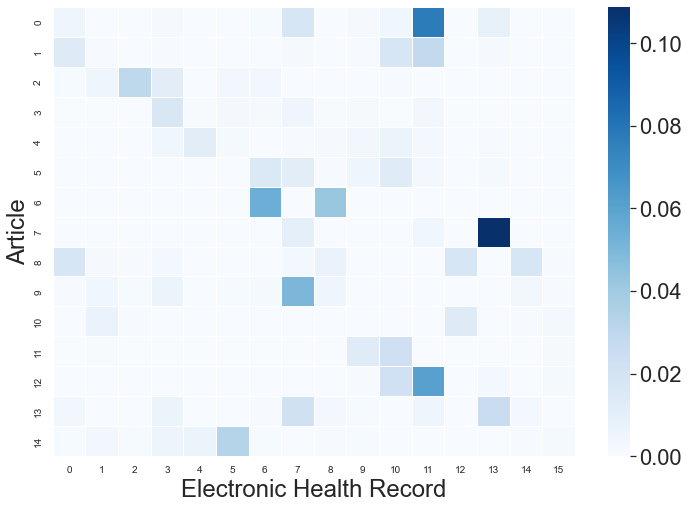

In [222]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=2)
transport_plan = intermediate_items_pos[3].cpu().data.numpy()[0,:positive_query_length,:cand_length]

# Print the sentences and plot the optimal transport plan for the pair of abstracts.
print('\n'.join([f'{i}: {s}' for i, s in enumerate(test_batch[0]['ABSTRACT'][:cand_length])]))
print('')
print('\n'.join([f'{i}: {s}' for i, s in enumerate(test_batch[1]['ABSTRACT'][:positive_query_length])]))

h = sns.heatmap(transport_plan, linewidths=.7, cmap='Blues')
h.set(xlabel='Electronic Health Record', ylabel='Article')
h.tick_params(labelsize=10)

# Saving the model

In [211]:
save_path = r"/cs/labs/tomhope/taltatal/aspire/models/{}"
model_name = r"tal-aspire-contextualsentence-multim-biomed-finetuned-train-only-cds2016-V3"
torch.save(aspire_mv_model.state_dict(), save_path.format(model_name))

# Loading the model

In [212]:
save_path = r"/cs/labs/tomhope/taltatal/aspire/models/{}"
model_name = r"tal-aspire-contextualsentence-multim-biomed-finetuned-train-only-cds2016-V1"
aspire_mv_model.load_state_dict(torch.load(save_path.format(model_name)))

<All keys matched successfully>